In [1]:
import numpy as np
import tbparse as tb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp

sns.set_theme()

In [2]:
lw = 3
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Table Results

In [4]:
#Three sig figs
map = lambda x: np.format_float_positional(x, precision=3, unique=False, fractional=False)

#Extract tb logs
dfs = []
for dataset in ["ignition/", "neuron_transport/", "channel_flow/"]:
    log_dir = "lightning_logs/"+dataset
    experiments = ["hnet_offline_full", "hnet_offline_subsample", "hnet_offline_fjlt", "hnet_online_baseline", "hnet_online_subsample", "hnet_online_fjlt"]
    
    df = pd.DataFrame(columns=["metric"]+experiments)
    df["metric"] = ["Mean PSNR", "Std PSNR", "Mean RFE", "Std RFE"]
    
    for i, experiment in enumerate(experiments):
        reader = tb.SummaryReader(log_dir+experiment)
        df_ = reader.scalars
        df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]
        
        df.loc[0,experiment] = map(np.mean(df_[df_["tag"] == "real_test_avg_PSNR"]["value"]))
        df.loc[1,experiment] = map(np.std(df_[df_["tag"] == "real_test_avg_PSNR"]["value"]))
        df.loc[2,experiment] = map(np.mean(df_[df_["tag"] == "real_test_avg_RFError"]["value"])*100)
        df.loc[3,experiment] = map(np.std(df_[df_["tag"] == "real_test_avg_RFError"]["value"])*100)

    dfs.append(df)

In [5]:
print("Ignition...")
dfs[0]

Ignition...


,metric,hnet_offline_full,hnet_offline_subsample,hnet_offline_fjlt,hnet_online_baseline,hnet_online_subsample,hnet_online_fjlt
0,Mean PSNR,41.6,37.3,37.1,9.28,40.2,41.7
1,Std PSNR,0.624,1.08,0.919,1.84,1.58,1.18
2,Mean RFE,2.17,4.04,3.87,84.2,3.89,2.64
3,Std RFE,0.193,0.353,0.492,7.22,2.11,0.852


In [6]:
print("Neuron Transport...")
dfs[1]

Neuron Transport...


,metric,hnet_offline_full,hnet_offline_subsample,hnet_offline_fjlt,hnet_online_baseline,hnet_online_subsample,hnet_online_fjlt
0,Mean PSNR,60.4,35.4,48.8,14.5,40.7,58.2
1,Std PSNR,0.362,5.58,6.46,1.60,11.8,0.819
2,Mean RFE,0.566,14.1,2.88,125.,21.0,0.754
3,Std RFE,0.051,20.4,2.28,23.3,36.3,0.0959


In [7]:
print("Channel Flow...")
dfs[2]

Channel Flow...


,metric,hnet_offline_full,hnet_offline_subsample,hnet_offline_fjlt,hnet_online_baseline,hnet_online_subsample,hnet_online_fjlt
0,Mean PSNR,37.4,34.3,34.6,14.3,37.4,37.4
1,Std PSNR,0.45,0.496,0.217,0.444,0.637,0.470
2,Mean RFE,5.37,7.67,7.30,77.2,5.27,5.22
3,Std RFE,0.362,0.464,0.259,1.59,0.46,0.371


# Neuron Transport: Performance v Sketch Size (FJLT)
Fixed compression rate with varying sketch sizes.

In [3]:
#Extract tb logs
log_dir = "lightning_logs/neuron_transport/"
experiments = [f"hnet_online_fjlt_%_{i}" for i in range(0,4)]
experiments.append("hnet_online_fjlt")

# df = pd.DataFrame(columns=["Sample Factor", "PSNR", "RFE"])
sample_factors = np.linspace(0.001, 0.01, 5)*100
dfs = []

for i, experiment in enumerate(experiments):
    reader = tb.SummaryReader(log_dir+experiment)
    df_ = reader.scalars
    PSNR = df_[df_["tag"] == "real_test_avg_PSNR"]["value"]
    RFE = df_[df_["tag"] == "real_test_avg_RFError"]["value"]*100

    dfs.append(pd.DataFrame({"Sample Factor": sample_factors[i], "PSNR": PSNR.to_numpy(), "RFE": RFE.to_numpy()}))

df = pd.concat(dfs, ignore_index=True)

In [4]:
df

,Sample Factor,PSNR,RFE
0,0.100,52.073406,2.824103
1,0.100,52.260994,2.955901
2,0.100,52.018097,2.994268
3,0.100,52.266544,3.029322
4,0.100,51.839809,2.749467
5,0.325,55.231533,2.012891
6,0.325,55.222870,1.789363
7,0.325,56.763950,1.389776
8,0.325,54.764339,2.135794
9,0.325,54.551746,1.836249


In [5]:
#Get offline baseline
df_ = tb.SummaryReader(log_dir+"hnet_offline_full").scalars
df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]

mean_PSNR = np.mean(df_[df_["tag"] == "real_test_avg_PSNR"]["value"])
mean_RFE = np.mean(df_[df_["tag"] == "real_test_avg_RFError"]["value"]*100)

In [6]:
mean_RFE

0.566486231982708

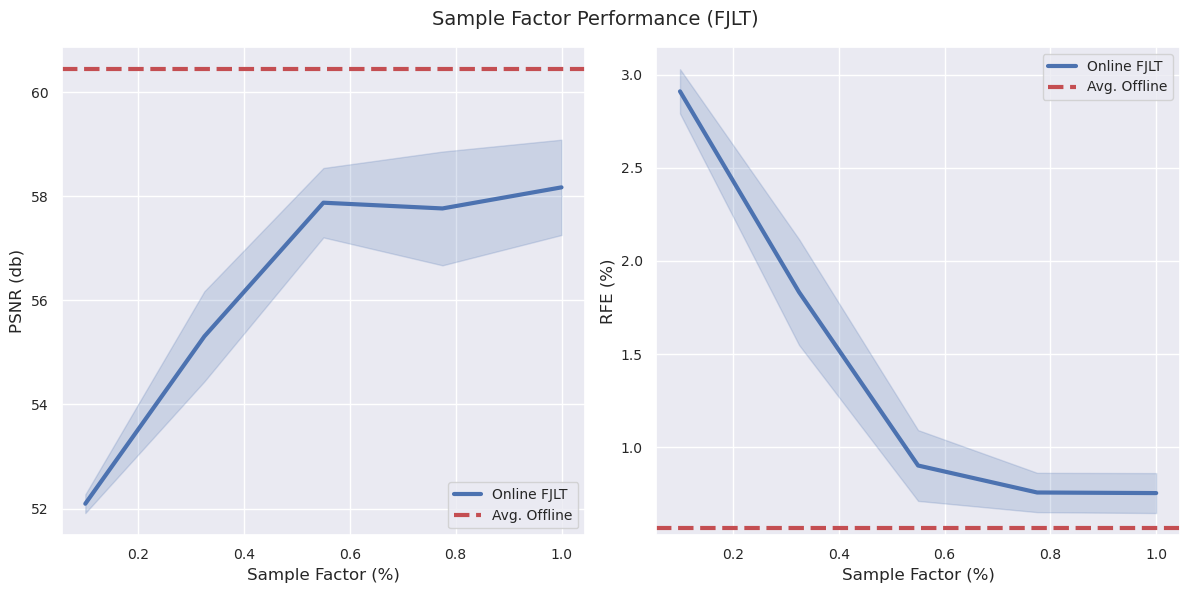

In [7]:
#Plot
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.lineplot(data=df, x="Sample Factor", y="PSNR", ax=ax[0], errorbar="sd", label="Online FJLT", lw=lw)
ax[0].axhline(mean_PSNR, c="r", ls="--", label="Avg. Offline", lw=lw)
ax[0].set_xlabel("Sample Factor (%)")
ax[0].set_ylabel("PSNR (db)")
ax[0].legend()

sns.lineplot(data=df, x="Sample Factor", y="RFE", ax=ax[1], errorbar="sd", label="Online FJLT", lw=lw)
ax[1].axhline(mean_RFE, c="r", ls="--", label="Avg. Offline", lw=lw)
ax[1].set_xlabel("Sample Factor (%)")
ax[1].set_ylabel("RFE (%)")
ax[1].legend()

fig.suptitle("Sample Factor Performance (FJLT)")

fig.tight_layout()

In [8]:
fig.savefig("misc/figures/sample-factor-performance-fjlt.pdf", bbox_inches="tight")

# Neuron Transport: Performance v Sketch Size (Subsample)
Fixed compression rate with varying sketch sizes.

In [20]:
#Extract tb logs
log_dir = "lightning_logs/neuron_transport/"
experiments = ["hnet_online_subsample"]
experiments.extend([f"hnet_online_subsample_%_{i}" for i in range(0,4)])

# df = pd.DataFrame(columns=["Sample Factor", "PSNR", "RFE"])
sample_factors = np.linspace(0.01, 0.05, 5)*100
dfs = []

for i, experiment in enumerate(experiments):
    reader = tb.SummaryReader(log_dir+experiment)
    df_ = reader.scalars
    PSNR = df_[df_["tag"] == "real_test_avg_PSNR"]["value"]
    RFE = df_[df_["tag"] == "real_test_avg_RFError"]["value"]*100

    dfs.append(pd.DataFrame({"Sample Factor": sample_factors[i], "PSNR": PSNR.to_numpy(), "RFE": RFE.to_numpy()}))

df = pd.concat(dfs, ignore_index=True)

In [21]:
df

,Sample Factor,PSNR,RFE
0,1.0,45.612446,3.881890
1,1.0,48.056469,3.647723
2,1.0,45.011135,4.201194
3,1.0,43.677048,4.773080
4,1.0,47.516541,3.237062
5,1.0,46.175896,4.043857
6,1.0,50.001461,3.003569
7,1.0,15.956475,99.640840
8,1.0,16.227995,96.540338
9,1.0,47.201786,3.594676


In [22]:
#Get offline baseline
df_ = tb.SummaryReader(log_dir+"hnet_offline_full").scalars
df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]

mean_PSNR = np.mean(df_[df_["tag"] == "real_test_avg_PSNR"]["value"])
mean_RFE = np.mean(df_[df_["tag"] == "real_test_avg_RFError"]["value"]*100)

In [23]:
mean_RFE

0.566486231982708

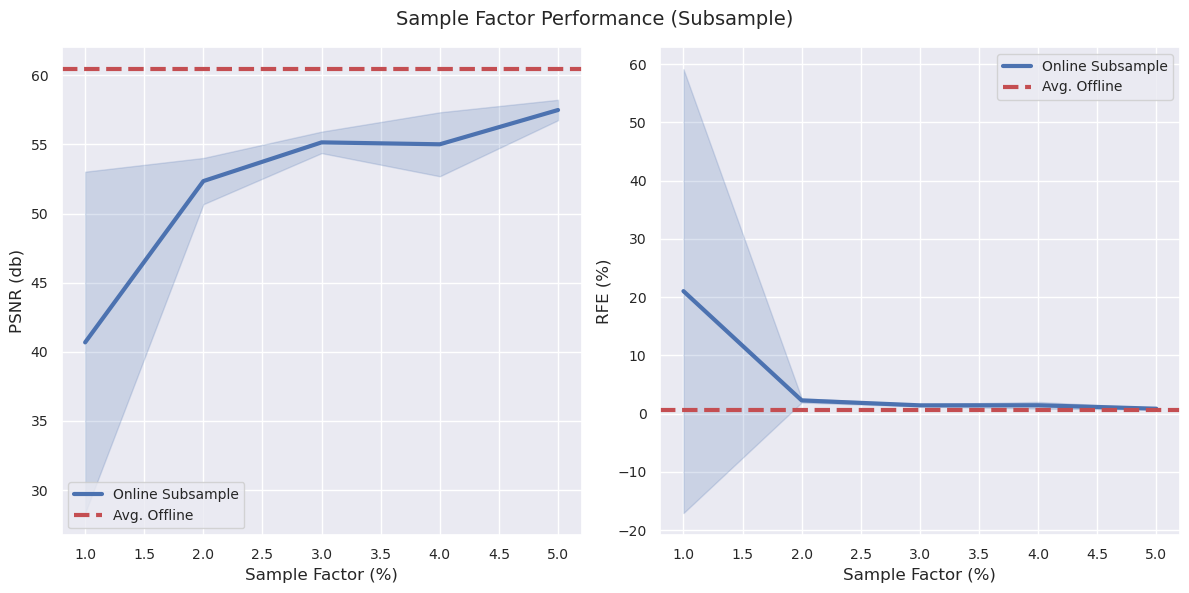

In [24]:
#Plot
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.lineplot(data=df, x="Sample Factor", y="PSNR", ax=ax[0], errorbar="sd", label="Online Subsample", lw=lw)
ax[0].axhline(mean_PSNR, c="r", ls="--", label="Avg. Offline", lw=lw)
ax[0].set_xlabel("Sample Factor (%)")
ax[0].set_ylabel("PSNR (db)")
ax[0].legend()

sns.lineplot(data=df, x="Sample Factor", y="RFE", ax=ax[1], errorbar="sd", label="Online Subsample", lw=lw)
ax[1].axhline(mean_RFE, c="r", ls="--", label="Avg. Offline", lw=lw)
ax[1].set_xlabel("Sample Factor (%)")
ax[1].set_ylabel("RFE (%)")
ax[1].legend()

fig.suptitle("Sample Factor Performance (Subsample)")

fig.tight_layout()

In [25]:
fig.savefig("misc/figures/sample-factor-performance-subsample.pdf", bbox_inches="tight")

# Ignition Plots

In [52]:
#Load Data
frame = 12

raw = np.load("data/ignition/features.npy")[frame,:,1].reshape(50,50)
r_baseline = np.load("lightning_logs/ignition/hnet_offline_full/version_3/reconstruction.npy")[frame,:,1].reshape(50,50)
r_off_sub = np.load("lightning_logs/ignition/hnet_offline_subsample/version_3/reconstruction.npy")[frame,:,1].reshape(50,50)
r_off_fjlt = np.load("lightning_logs/ignition/hnet_offline_fjlt/version_3/reconstruction.npy")[frame,:,1].reshape(50,50)
r_sub = np.load("lightning_logs/ignition/hnet_online_subsample/version_3/reconstruction.npy")[frame,:,1].reshape(50,50)
r_fjlt = np.load("lightning_logs/ignition/hnet_online_fjlt/version_3/reconstruction.npy")[frame,:,1].reshape(50,50)

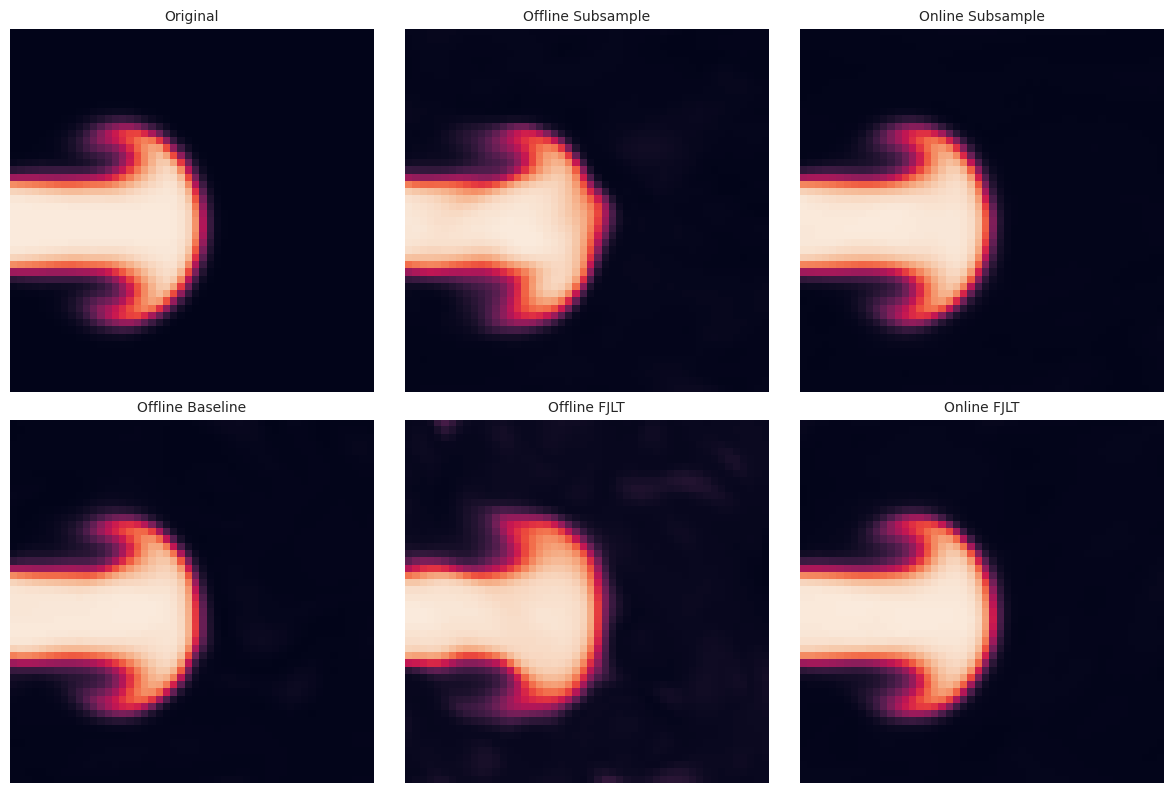

In [54]:
fig, axs = plt.subplots(2,3,figsize=(12,8))

axs[0,0].imshow(raw)
axs[0,0].set_title("Original")

axs[1,0].imshow(r_baseline)
axs[1,0].set_title("Offline Baseline")

axs[0,1].imshow(r_off_sub)
axs[0,1].set_title("Offline Subsample")

axs[1,1].imshow(r_off_fjlt)
axs[1,1].set_title("Offline FJLT")

axs[0,2].imshow(r_sub)
axs[0,2].set_title("Online Subsample")

axs[1,2].imshow(r_fjlt)
axs[1,2].set_title("Online FJLT")

for ax in np.ravel(axs):
    ax.grid(False)
    ax.axis(False)

fig.tight_layout()

In [55]:
fig.savefig("misc/figures/ignition-comparison.pdf",bbox_inches='tight')

In [47]:
#Load Data
df = tb.SummaryReader("lightning_logs/ignition/hnet_online_fjlt/version_3/events.out.tfevents.1726546773.bgpu-biokem2.rc.int.colorado.edu.780349.0").scalars
full = df[df['tag']=='train_loss_1']['value'].to_numpy()
sketch = df[df['tag']=='train_loss_2']['value'].to_numpy()

full = full[499::500]
sketch = sketch[499::500]

#Testing error
raw = np.load("data/ignition/features.npy")[:,:,[1]]
r_fjlt = np.load("lightning_logs/ignition/hnet_online_fjlt/version_3/reconstruction.npy")[:,:,[1]]

n = np.sum((raw-r_fjlt)**2, axis=(1,2))
d = np.sum((raw)**2, axis=(1,2))

test = np.sqrt(n/d)

#Baseline testing error

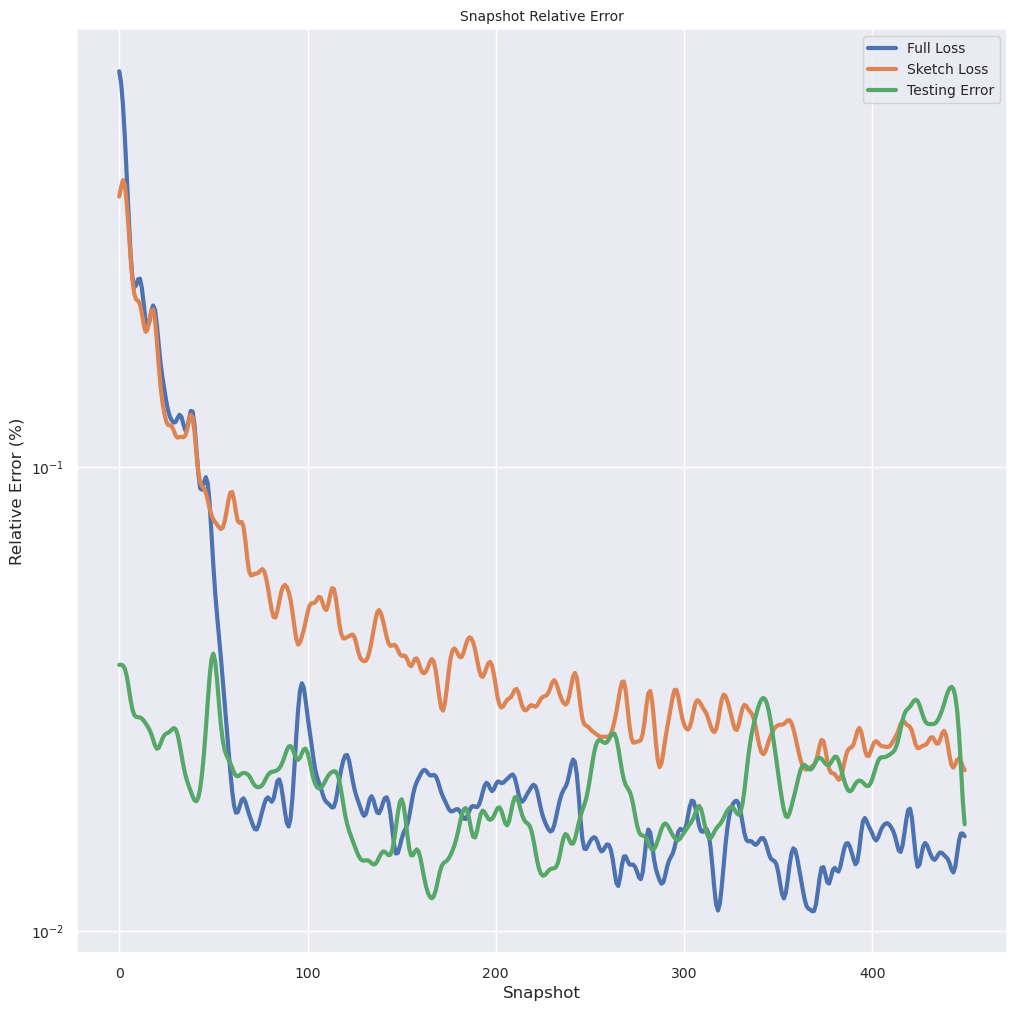

In [48]:
fig, ax = plt.subplots(1,1,figsize=(12,12))

# ax.semilogy(full)
# ax.semilogy(sketch)
# ax.semilogy(test)

ax.semilogy(scp.ndimage.gaussian_filter(full, 2.0), lw=lw)
ax.semilogy(scp.ndimage.gaussian_filter(sketch, 2.0), lw=lw)
ax.semilogy(scp.ndimage.gaussian_filter(test, 2.0), lw=lw)

ax.set_title("Snapshot Relative Error")
ax.set_xlabel("Snapshot")
ax.set_ylabel("Relative Error (%)")
ax.legend(["Full Loss", "Sketch Loss", "Testing Error"])

In [49]:
fig.savefig("misc/figures/ignition-r3error.pdf", bbox_inches="tight")

# Channel Flow

In [9]:
#Load Data
frame = 249
z_slice = 31

raw = np.load("data/channel_flow/features_64_500.npy")[frame,:,:].reshape(64,64,64,-1)[:,:,z_slice,:]
r_baseline = np.load("lightning_logs/channel_flow/hnet_offline_full/version_2/reconstruction.npy")[frame,:,:].reshape(64,64,64,-1)[:,:,z_slice,:]
r_subsample = np.load("lightning_logs/channel_flow/hnet_online_subsample/version_4/reconstruction.npy")[frame,:,:].reshape(64,64,64,-1)[:,:,z_slice,:]
r_fjlt = np.load("lightning_logs/channel_flow/hnet_online_fjlt/version_4/reconstruction.npy")[frame,:,:].reshape(64,64,64,-1)[:,:,z_slice,:]

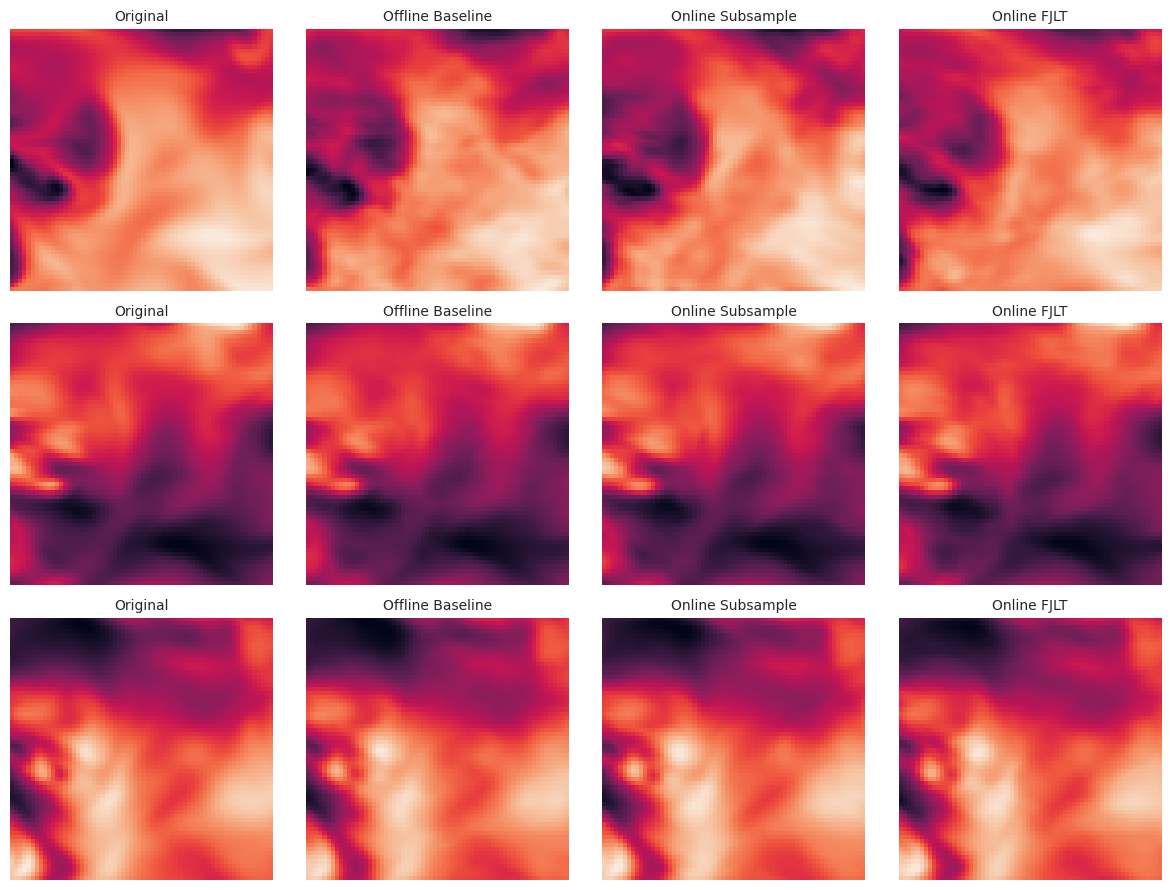

In [10]:
fig, axs = plt.subplots(3,4,figsize=(12,9))

for i in range(3):
    axs[i,0].imshow(raw[:,:,i])
    axs[i,0].set_title("Original")
    
    axs[i,1].imshow(r_baseline[:,:,i])
    axs[i,1].set_title("Offline Baseline")

    axs[i,2].imshow(r_subsample[:,:,i])
    axs[i,2].set_title("Online Subsample")
    
    axs[i,3].imshow(r_fjlt[:,:,i])
    axs[i,3].set_title("Online FJLT")

for ax in np.ravel(axs):
    ax.grid(False)
    ax.axis(False)

fig.tight_layout()

In [11]:
fig.savefig("misc/figures/channel-flow-comparison.pdf", bbox_inches='tight')